# Sentiment Analysis on Movie Reviews
## Classify the sentiment of sentences from the Rotten Tomatoes dataset

In this Kaggle project, I attempt to classify the sentiment of sentences from the [Rotten Tomatoes](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/data) dataset using several feature engineering (tokenisation, cleaning the text and removing stop words, using Word2vec embedding, lematization and normalisation) and Machine Learning techniques (including Deep Learning). Before applying the Word2vec embedding on the data, I first updated the weights of the word vectors with the Google News corpus. This improved the accuracy by roughly 5% -6%. Normalisation (min-max scaling) further improved the accuracy of the model (in some cases close to 10%). Although the model with the best validation accuracy consisted of a random forest; the aforementioned model grossly over-fitted the data. The best model in term of both performance and not over-fitting the data was a feed-forward neural network.

The sentiment labels are:

0. negative
1. somewhat negative
2. neutral
3. somewhat positive
4. positive

The workflow consists of the following steps:


* Exploring the data and creating new features
* Pre-processing and vectorization
* Developing a classifier for predicting the sentiment

First, I imported all the packages necessary for visualisation and pre-processing and set my working directory.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
warnings.filterwarnings(action = 'ignore') 

import os
for dirname, _, filenames in os.walk('D:\Study\Datasets\Sentiment Analysis on Movie Reviews'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Next, I read the data downloaded from Kaggle and created the training and test datasets.

In [2]:
training = pd.read_csv("/content/train.tsv", sep='\t')
test = pd.read_csv("/content/train.tsv", sep='\t')

In [ ]:
%matplotlib inline
training.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


## Exploring the data and creating new features

In order to explore the data and perform further transformations, I first joined the training and testing datasets.

In [4]:
training['train_test'] = 1
test['train_test'] = 0
test['Sentiment'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

pd.set_option('display.max_colwidth', 100000)

all_data.Phrase=all_data.Phrase.str.strip()

In [ ]:
all_data.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,train_test
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1
2,3,1,A series,2.0,1
3,4,1,A,2.0,1
4,5,1,series,2.0,1
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1
6,7,1,of,2.0,1
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1
8,9,1,escapades,2.0,1
9,10,1,demonstrating the adage that what is good for the goose,2.0,1


In [ ]:
all_data.shape

(312120, 5)

Let us  is now create a frequency count for the Sentiment column.

In [ ]:
all_data.Sentiment.value_counts()

2.0    79582
3.0    32927
1.0    27273
4.0     9206
0.0     7072
Name: Sentiment, dtype: int64

2.0    0.254972
3.0    0.105495
1.0    0.087380
4.0    0.029495
0.0    0.022658
Name: Sentiment, dtype: float64


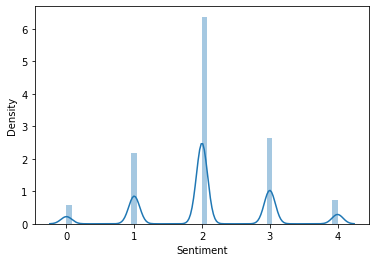

In [ ]:
print(all_data.Sentiment.value_counts() / len(all_data))

%matplotlib inline
sns.distplot(all_data.loc[all_data['train_test']==1,"Sentiment"])

The majority of reviews (around 36%) are neutral. 

In [ ]:
word_tokens = [word_tokenize(review.lower()) for review in all_data.Phrase]

print(word_tokens[0:5])

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series']]


In [ ]:
len_tokens = []

# Iterate over the word_tokens list
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    
all_data['n_tokens'] = len_tokens

In [ ]:
all_data.sort_values(by='n_tokens', ascending=False).head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens
18578,18579,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie .",NaN,0,53
18578,18579,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie .",1.0,1,53
75357,75358,3866,"Build some robots , haul 'em to the theatre with you for the late show , and put on your own Mystery Science Theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year .",0.0,1,52
18579,18580,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie",NaN,0,52
87835,87836,4563,"There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .",4.0,1,52
87835,87836,4563,"There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .",NaN,0,52
35598,35599,1678,"It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .",NaN,0,52
35598,35599,1678,"It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .",4.0,1,52
75357,75358,3866,"Build some robots , haul 'em to the theatre with you for the late show , and put on your own Mystery Science Theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year .",NaN,0,52
18579,18580,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie",1.0,1,52


The new columns created consist of Polarity, Subjectivity and the number of tokens (nb. of words per observation). Polarity ranges between -1 and 1; with a polarity greater than 0.5 illustrating a positive sentiment, a polarity lower than -0.5 a negative one and a polarity between -0.5 and 0.5 illustrating a neutral sentiment. Subjectivity, on the other hand ranges between 0 and 1. A higher subjectivity suggests a more emotionally charged word/phrase.

In [ ]:
from pandas import DataFrame

def Polarity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.polarity

def Subjectivity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.subjectivity

all_data['Polarity']=all_data['Phrase'].apply(Polarity)
all_data['Subjectivity']=all_data['Phrase'].apply(Subjectivity)

In [ ]:
all_data.head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000
2,3,1,A series,2.0,1,2,0.0,0.00000
3,4,1,A,2.0,1,1,0.0,0.00000
4,5,1,series,2.0,1,1,0.0,0.00000
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1,12,0.7,0.60000
6,7,1,of,2.0,1,1,0.0,0.00000
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1,11,0.7,0.60000
8,9,1,escapades,2.0,1,1,0.0,0.00000
9,10,1,demonstrating the adage that what is good for the goose,2.0,1,10,0.7,0.60000


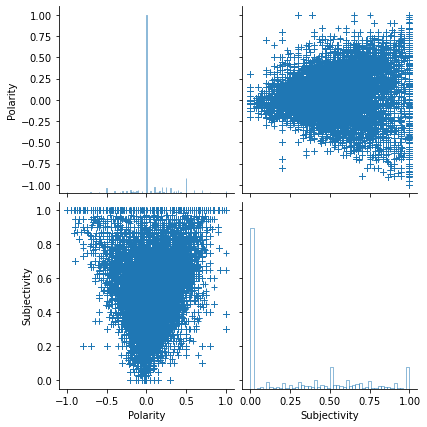

In [ ]:
%matplotlib inline
sns.pairplot(all_data.loc[all_data['train_test']==1,["Polarity","Subjectivity"]],plot_kws=dict(marker="+", linewidth=1),diag_kws=dict(fill=False),
height=3)

Although the majority of observations has a polarity of 0 (neutral); corresponding to a Sentiment of 2 (agreeing with the distribution of the Sentiment distribution plot), it can clearly be noticed how the second (index 1) polarity value (0.7- positive) overestimates the  positivity of the first two sentences sentences when compared to the respective sentiment value (2- neutral). This is because polarity alone does not distinguish context nor sarcasm. The subjectivity value of 0.6 suggests a rather emotionally charged phrase. The same applies to row 6 (index 5). Notice how the presence of "A series" in the phrase does not influence polarity nor subjectivity in any way. A big reason for the frequent values of 0 afferent to both the polarity and subjectivity columns consists of the presence of rows that only have stop words in the Phrase column.

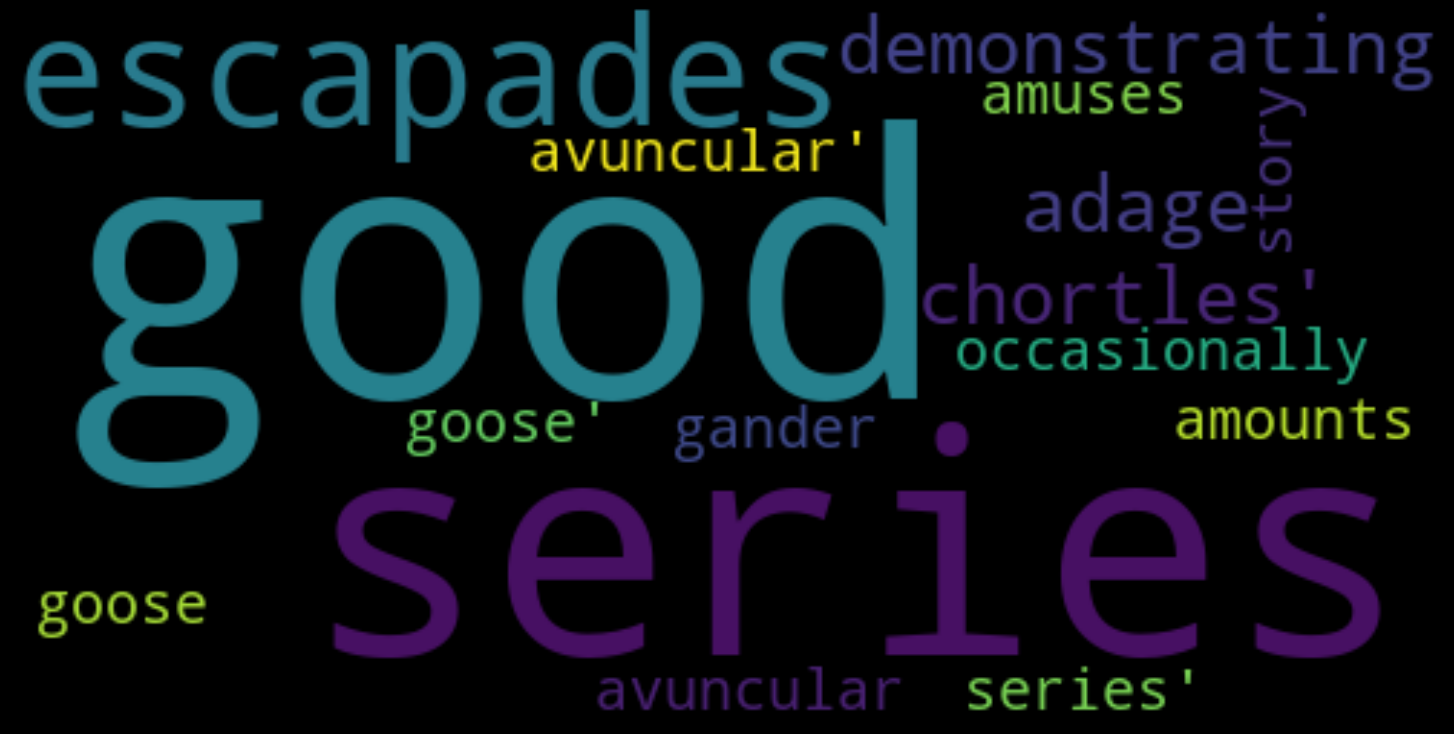

In [5]:
text = all_data.Phrase.values
wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

According to the word cloud, the second most frequent word is "series"; which does not have neither a positive nor negative meaning. This word does not bring any added value and is repeated for most of the series reviewed on Rotten Tomatoes. This noun along with others and articles such as "a" and "the" are candidates for stop words (i.e. removing them might be beneficial).

## Pre-processing and vectorization


In [6]:
x_train = all_data[all_data.train_test==1]
x_test = all_data[all_data.train_test==0]
y_train = all_data[all_data.train_test==1].Sentiment

In [ ]:
x_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,train_test
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1
2,3,1,A series,2.0,1
3,4,1,A,2.0,1
4,5,1,series,2.0,1


In [7]:
#First we clean the data

tokenized_text = all_data['Phrase'].apply(lambda x: simple_preprocess(x.lower(), deacc=True))
tokenized_text =tokenized_text.apply(lambda x: [remove_stopwords(i) for i in x])
WNlemmatizer = WordNetLemmatizer()

lemmatized_tokens = tokenized_text.apply(lambda x: [WNlemmatizer.lemmatize(i) for i in x])

In [8]:
all_data['tokenized_text'] = lemmatized_tokens

In [ ]:
all_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity,tokenized_text
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125,"[series, , escapade, demonstrating, , adage, , , , good, , , goose, , , good, , , gander, , , , occasionally, amuses, , , , , amount, , , , story]"
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000,"[series, , escapade, demonstrating, , adage, , , , good, , , goose]"
2,3,1,A series,2.0,1,2,0.0,0.00000,[series]
3,4,1,A,2.0,1,1,0.0,0.00000,[]
4,5,1,series,2.0,1,1,0.0,0.00000,[series]


[list(['series', '', 'escapade', 'demonstrating', '', 'adage', '', '', '', 'good', '', '', 'goose', '', '', 'good', '', '', 'gander', '', '', '', 'occasionally', 'amuses', '', '', '', '', 'amount', '', '', '', 'story'])
 list(['series', '', 'escapade', 'demonstrating', '', 'adage', '', '', '', 'good', '', '', 'goose'])
 list(['series']) list([]) list(['series'])]


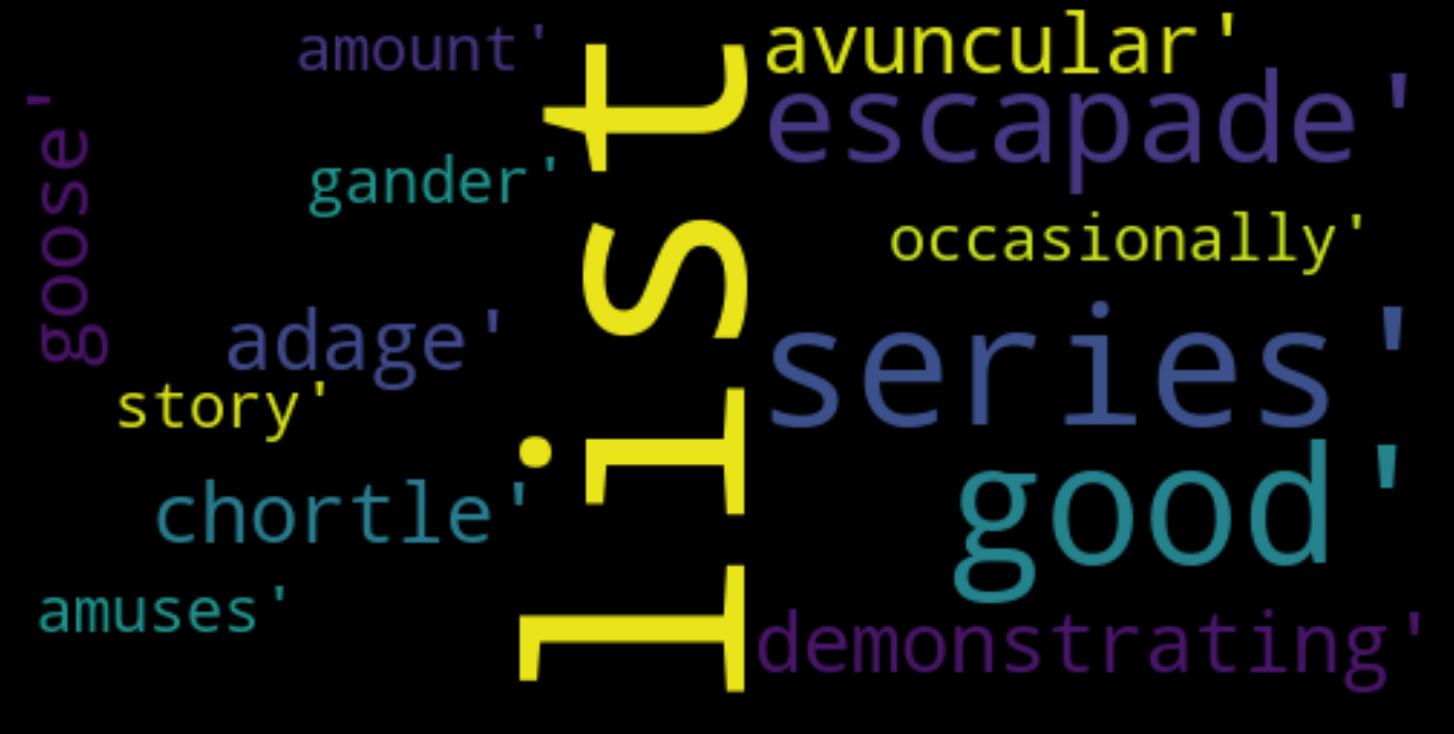

In [9]:
tokenized_text = pd.Series(all_data['tokenized_text']).values

print(tokenized_text[0:5])

wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(tokenized_text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
print(STOPWORDS)

frozenset({'alone', 'forty', 'our', 'might', 'un', 'somewhere', 'less', 'various', 'yourself', 'on', 'they', 'ten', 'three', 'should', 'by', 'hereby', 'my', 'don', 'am', 'now', 'a', 'put', 'afterwards', 'nevertheless', 'herself', 'itself', 'becomes', 'mostly', 'doesn', 'there', 'not', 'back', 'its', 'have', 'nothing', 'whatever', 'whence', 'i', 'whole', 'been', 'fifteen', 'among', 'next', 'just', 'both', 'co', 'otherwise', 'except', 'unless', 'own', 'still', 'whether', 'toward', 'us', 'didn', 'either', 'whereby', 'per', 'system', 'show', 'inc', 'no', 'therein', 'during', 'throughout', 'third', 'bottom', 'because', 'beyond', 'another', 'former', 'least', 'please', 'however', 'within', 'hasnt', 'several', 'call', 'other', 'if', 'is', 'else', 'even', 'became', 'thence', 'herein', 'an', 'cannot', 'everyone', 'where', 'top', 'seeming', 'almost', 'few', 'their', 'found', 'into', 'through', 'whose', 'each', 'amongst', 'twenty', 'without', 'six', 'eg', 'say', 'again', 'them', 'too', 'then', 'a

In [10]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
import time

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [11]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-01-17 14:38:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.79.182
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.79.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  72.4MB/s    in 21s     

2021-01-17 14:38:33 (75.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [12]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above

In [13]:
# Train a bigram detector.
bigram_transformer = Phrases(tokenized_text)

# Create Skip-Gram model 
w2v_model = Word2Vec(min_count = 2,  size = 300,window = 15, workers=20,sg=1,negative=5,sample=1e-05)
w2v_model.build_vocab(tokenized_text)
w2v_model_0 = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
w2v_model.build_vocab([list(w2v_model_0.vocab.keys())], update=True)
w2v_model.intersect_word2vec_format(EMBEDDING_FILE, binary=True, lockf=1.0)
  
# train the w2v model
start = time.time()
w2v_model.train(bigram_transformer[tokenized_text], 
                total_examples=w2v_model.corpus_count, 
                epochs=501, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsed time in seconds :"+ str(end - start))             

Loss after epoch 0: 1320585.25
Loss after epoch 100: 173332.0
Loss after epoch 200: 184728.0
Loss after epoch 300: 22216.0
Loss after epoch 400: 14792.0
Loss after epoch 500: 8496.0
elapsed time in seconds :3504.712000131607


In [ ]:
words = list(w2v_model.wv.vocab)
print('Vocab size: '+str(len(words)))

Vocab size: 13443


In [ ]:
# Print results

print("Cosine similarity between 'goose' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('goose', 'gander')) 

print("Cosine similarity between 'story' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander')) 
      
print("Cosine similarity between 'story' " + 
               "and 'adage' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander'))

print("Cosine similarity between 'long' " + 
               "and 'winded' - Skip-Gram : ", 
    w2v_model.similarity('long', 'winded'))

Cosine similarity between 'goose' and 'gander' - Skip-Gram :  0.77558684
Cosine similarity between 'story' and 'gander' - Skip-Gram :  0.36128524
Cosine similarity between 'story' and 'adage' - Skip-Gram :  0.36128524
Cosine similarity between 'long' and 'winded' - Skip-Gram :  0.42999172


In [ ]:
# calculate: (gander - story) + goose = ?
result = w2v_model.most_similar(positive=['goose', 'gander'], negative=['story'], topn=1)
print(result)

[('cremaster', 0.647571325302124)]


The words 'goose' and 'gander' have, as expected, the highest cosine similarity. The pairs of words 'story' and 'gander', respectively 'story' and 'adage' have much lower similarity values (which makes sense). As expected, the pair 'long' and 'winded' has a high cosine similarity given that  'long-winded' means 'unecessarily long'; even though the primary meaning of 'winded' is not long. Also, I would expect a lower similarity for the pairs 'story' and 'adage', respectively 'story' and  'gander'. These estimates are mainly influenced by word pairs frequencies. For instance, because 'goose' and 'gander' appear frequently together, they have a higher similarity value. Usually, the models based on Word2vec are trained on very large corpi of text. Here, and the accuracy of the similarity estimates is mainly impacted by the size, window and negative sample size hyperparameters of the Word2Vec() estimator.

Note: In order to improve the performance of the model, I updated the vector weights using the Google News corpus.

In [26]:
result = w2v_model.most_similar(positive='good',topn=20)
print(result)

[('better', 0.6443471312522888), ('hopefully', 0.6230648159980774), ('fresnadillo', 0.6043255925178528), ('terrific', 0.5844765901565552), ('pretty', 0.5776930451393127), ('decent', 0.5729144811630249), ('lot', 0.5678906440734863), ('nice', 0.5651593804359436), ('bad', 0.5610318183898926), ('great', 0.5585672855377197), ('stuff', 0.5582649111747742), ('one', 0.552747368812561), ('excellent', 0.5509063005447388), ('minded', 0.5378695130348206), ('eyre', 0.5346391201019287), ('fantastic', 0.5336673259735107), ('distort', 0.5309920907020569), ('adage', 0.5299543738365173), ('impressed', 0.5270936489105225), ('chouraqui', 0.526979923248291)]


In [27]:
result = w2v_model.most_similar(positive='bad',topn=20)
print(result)

[('poor', 0.688922643661499), ('terrible', 0.630290150642395), ('lousy', 0.6151150465011597), ('horrible', 0.6131336688995361), ('bluescreen', 0.5638686418533325), ('good', 0.5610317587852478), ('radical', 0.552564263343811), ('atrocious', 0.5451430678367615), ('dreadful', 0.5364598035812378), ('playing', 0.5350823402404785), ('awful', 0.5341538786888123), ('horrid', 0.5307971239089966), ('kingsley', 0.5259902477264404), ('crummy', 0.522559642791748), ('crappy', 0.5175868272781372), ('worse', 0.5095962882041931), ('tough', 0.5093909502029419), ('highlight', 0.5079731941223145), ('ugly', 0.5031680464744568), ('home', 0.5030412077903748)]


Although for most of the part the word 'good' has a high similarity to positive words and the word 'bad' has a high cosine similarity to negative words, the words 'good' and 'bad' have a 56% cosine similarity. This might be due to the fact that the algorithm only looks at word pairs freuencies and is not able to detect sarcasm. Overall, the results are good enough given the relatively small size of the vocabulary in both the training and test data (even though the weights are updated using the Google News corpus).

In [14]:
#Next, I will add zero padding and reshape the Word 2 Vec model to create a word vector array.
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [15]:
wordvec_arrays = np.zeros((len(tokenized_text), 300))

for i in range(len(tokenized_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 300)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(312120, 300)

In [ ]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.083684,0.109168,-0.052196,0.072759,-0.029808,0.036897,0.180874,0.023090,0.080070,0.192491,-0.096874,-0.209689,0.019115,0.045341,-0.135327,0.132078,0.016476,0.135467,-0.047600,-0.179400,0.066450,0.064935,0.079826,0.009953,0.055851,0.001973,-0.050243,0.144967,0.010374,0.063109,-0.100570,-0.038968,0.030515,-0.000945,0.017663,0.075012,0.087102,0.027223,0.131654,0.181067,...,-0.003938,0.054342,-0.113831,-0.003489,0.062346,0.142836,-0.055639,-0.119412,-0.093860,-0.104822,0.055483,0.163149,0.050279,0.013154,0.066491,-0.083715,-0.015221,-0.027703,-0.077705,0.086953,0.030563,-0.080796,0.060993,0.031878,-0.020321,-0.040370,-0.128953,0.077080,0.043858,0.078690,-0.062108,0.023223,-0.105244,-0.040446,-0.083147,-0.062932,0.073014,-0.131568,0.014706,0.028816
1,0.098538,0.186104,-0.088659,0.107636,-0.018982,0.093465,0.188088,-0.003078,0.123083,0.265475,-0.101640,-0.317313,0.012882,0.066487,-0.163388,0.143956,0.011924,0.171836,-0.080096,-0.259460,0.119636,0.114129,0.109301,-0.001074,0.056709,0.027931,-0.051203,0.199597,0.052928,0.073722,-0.128822,-0.054596,0.043801,0.006062,0.033207,0.135033,0.110948,0.006946,0.234273,0.195755,...,0.018131,0.114856,-0.116305,0.006336,0.112337,0.193841,-0.052224,-0.147068,-0.131302,-0.109545,0.050195,0.209643,0.089004,0.024637,0.088756,-0.113469,-0.021432,0.002129,-0.108278,0.133999,0.021464,-0.075817,0.106380,0.031039,-0.038136,-0.088894,-0.139278,0.094618,0.095479,0.114012,-0.064473,0.038875,-0.163439,-0.058096,-0.086464,-0.103527,0.098682,-0.156325,0.008882,0.043312
2,-0.135689,0.461635,-0.130607,0.088486,0.298172,0.313690,0.290971,-0.040563,0.249950,0.480264,-0.069417,-0.392690,0.086983,0.169266,-0.309520,0.088729,-0.087177,0.311202,0.100061,-0.219098,0.482593,0.177603,0.056259,-0.168099,-0.109394,0.274365,-0.071762,0.508618,-0.016059,0.086730,-0.504644,-0.195151,-0.022865,-0.211630,0.184045,0.191949,0.319423,-0.117767,0.439072,0.153550,...,0.040678,0.633528,0.043856,-0.260589,0.262808,0.321440,-0.102952,-0.052341,-0.156881,-0.325226,0.279965,0.191842,0.053233,0.172091,0.486170,-0.032922,-0.108906,-0.269264,-0.107490,-0.009067,-0.143616,-0.498193,0.286821,0.101989,-0.003869,-0.344570,-0.266747,-0.124115,-0.026574,0.086490,-0.027042,-0.189163,-0.137937,-0.334790,-0.149657,-0.283441,0.057044,-0.170258,-0.173930,-0.236226
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.135689,0.461635,-0.130607,0.088486,0.298172,0.313690,0.290971,-0.040563,0.249950,0.480264,-0.069417,-0.392690,0.086983,0.169266,-0.309520,0.088729,-0.087177,0.311202,0.100061,-0.219098,0.482593,0.177603,0.056259,-0.168099,-0.109394,0.274365,-0.071762,0.508618,-0.016059,0.086730,-0.504644,-0.195151,-0.022865,-0.211630,0.184045,0.191949,0.319423,-0.117767,0.439072,0.153550,...,0.040678,0.633528,0.043856,-0.260589,0.262808,0.321440,-0.102952,-0.052341,-0.156881,-0.325226,0.279965,0.191842,0.053233,0.172091,0.486170,-0.032922,-0.108906,-0.269264,-0.107490,-0.009067,-0.143616,-0.498193,0.286821,0.101989,-0.003869,-0.344570,-0.266747,-0.124115,-0.026574,0.086490,-0.027042,-0.189163,-0.137937,-0.334790,-0.149

In [16]:
from sklearn.model_selection import train_test_split

x_train_w2v_v0 = wordvec_df.iloc[:156060,:]
x_test_w2v = wordvec_df.iloc[156060:,:]
_, _,y_train_w2v, y_val_w2v = train_test_split(x_train_w2v_v0, y_train,  
                                                          random_state=1, 
                                                          test_size=0.3)



print(x_train_w2v_v0.shape, y_train.shape)
print(y_train_w2v.shape, y_val_w2v.shape)

x_train_w2v = x_train_w2v_v0.iloc[y_train_w2v.index,:]
x_val_w2v = x_train_w2v_v0.iloc[y_val_w2v.index,:]

(156060, 300) (156060,)
(109242,) (46818,)


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_w2v = scaler.fit_transform(x_train_w2v)
x_train_w2v = pd.DataFrame(x_train_w2v)

x_val_w2v= scaler.transform(x_val_w2v)
x_val_w2v = pd.DataFrame(x_val_w2v)
x_val_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.412126,0.480343,0.570478,0.323751,0.727702,0.511068,0.350962,0.644146,0.332954,0.423653,0.562416,0.722401,0.551596,0.383232,0.572706,0.324245,0.499372,0.287018,0.392751,0.469810,0.498617,0.497875,0.436233,0.479961,0.593041,0.708564,0.646711,0.327687,0.527983,0.573517,0.435409,0.509393,0.728863,0.489406,0.441424,0.660281,0.330866,0.507003,0.406706,0.359382,...,0.426330,0.624419,0.667552,0.486829,0.515706,0.273029,0.502931,0.603418,0.655807,0.543874,0.463633,0.379508,0.488761,0.488174,0.487225,0.555967,0.731806,0.469544,0.527832,0.345427,0.439727,0.414730,0.453477,0.408574,0.430998,0.560718,0.655392,0.423849,0.367045,0.357826,0.650671,0.628131,0.612000,0.586338,0.649108,0.649169,0.439887,0.640881,0.543338,0.416016
1,0.417793,0.367324,0.500243,0.388361,0.604646,0.462371,0.393908,0.576450,0.313322,0.408637,0.500537,0.729699,0.600350,0.404874,0.599005,0.342346,0.429769,0.351828,0.488970,0.656600,0.502933,0.469937,0.493996,0.486594,0.442099,0.573210,0.630955,0.405046,0.473092,0.610437,0.566689,0.448014,0.582867,0.513838,0.453110,0.537790,0.367115,0.426274,0.372599,0.336594,...,0.579552,0.518396,0.587803,0.528113,0.498750,0.236471,0.452928,0.615802,0.625357,0.522153,0.426290,0.341803,0.476858,0.538602,0.487564,0.559794,0.615750,0.515017,0.565246,0.376803,0.388000,0.494830,0.516841,0.400453,0.440782,0.550976,0.664815,0.487760,0.427984,0.418900,0.701840,0.464006,0.612847,0.611240,0.615149,0.558311,0.485621,0.605260,0.470317,0.453906
2,0.414998,0.370579,0.516014,0.371741,0.537381,0.388657,0.322486,0.731798,0.408869,0.339882,0.539714,0.683783,0.571594,0.448996,0.580514,0.371921,0.508313,0.269478,0.427395,0.672472,0.551220,0.482158,0.517299,0.521781,0.539091,0.565833,0.668430,0.364110,0.494642,0.607778,0.502416,0.357542,0.588683,0.509659,0.506524,0.570899,0.395674,0.450467,0.389298,0.356958,...,0.587404,0.595457,0.574016,0.516587,0.420433,0.296557,0.445920,0.596885,0.695142,0.483754,0.415010,0.299609,0.488703,0.505116,0.472277,0.558483,0.605033,0.570149,0.551556,0.368747,0.399789,0.517837,0.540463,0.548818,0.477033,0.554502,0.594196,0.475625,0.506531,0.273710,0.723996,0.457614,0.576330,0.546680,0.526724,0.613906,0.490566,0.677650,0.471878,0.415466
3,0.339702,0.332585,0.544975,0.319750,0.580450,0.438728,0.332571,0.622443,0.340038,0.292839,0.536323,0.674018,0.525373,0.315523,0.625582,0.383403,0.347340,0.397517,0.455752,0.680751,0.443865,0.445334,0.576916,0.404408,0.507675,0.624865,0.653545,0.344028,0.506565,0.422484,0.514846,0.555858,0.583816,0.521622,0.435139,0.548238,0.343322,0.437324,0.375571,0.435395,...,0.551811,0.439546,0.526679,0.502893,0.453642,0.309837,0.561498,0.631895,0.642704,0.603837,0.452422,0.353919,0.566356,0.610693,0.402680,0.548004,0.686923,0.476706,0.568576,0.268517,0.422607,0.506199,0.443739,0.481981,0.552134,0.541204,0.606108,0.452841,0.491011,0.386398,0.747148,0.508231,0.588753,0.601319,0.558649,0.531336,0.511786,0.564288,0.498716,0.367305
4,0.387643,0.365959,0.536342,0.335963,0.626429,0.476376,0.404692,0.631660,0.324114,0.400840,0.555258,0.690869,0.608117,0.413463,0.653510,0.364066,0.471374,0.339097,0.560422,0.707258,0.551538,0.490838,0.504569,0.482091,0.421517,0.520757,0.648039,0.424135,0.503588,0.550002,0.471624,0.416138,0.663392,0.602346,0.421157,0.544430,0.310302,0.430509,0.373080,0.435542,...,0.598564,0.513000,0.646246,0.520761,0.484324,0.339843,0.418564,0.571182,0.576170,0.518719,0.453713,0.358827,0.463553,0.521733,0.468916,0.577607,0.684927,0.549402,0.596373,0.356782,0.386565,0.479080,0.395894,0.400195,0.455378,0.535781,0.634660,0.468248,0.437147,0.384511,0.682512,0.520814,0.591644,0.675884,0.482285,0.558904,0.519914,0.552256,0.483894,0.416300


## Developing a classifier for predicting the sentiment

In this part I employed several Machine Learning models and tuned the best performing one. I also tried some undersampling and oversampling; with no significant improvements in accuracy. The final results afferent to both the training and the test data are illustrated below:

| Model | Accuracy on training data | Accuracy on validation data |
| --- | --- | --- |
| Gaussian Naive Bayes | 27.46% | 27.21%|
| Gaussian Naive Bayes after undersampling | 27.45% | 27.28%|
| Bernoulli Naive Bayes | 51.06% | 50.85%|
| Bernoulli Naive Bayes after SMOTE | 20.14% | 4.77%|
| Multinomial Naive Bayes| 51.05% | 50.87%|
| Logistic regression | 56.13% | 55.81% |
| Logistic regression after undersampling | 56.14% | 55.82%|
| Logistic regression after SMOTE | 45.96% | 41.5%|
| Decision tree classifier |94.01% | 52.47% |
| Tuned decision tree classifier |70.25% | 53.94% |
| Decision tree classifier after SMOTE |96.27% | 37.11% |
| K nearest neighbor | 71.96% | 58.83% |
| Tuned K nearest neighbour (6 neighbours with weight based on distance)| 94.01% | 61.30% |
| Random forest classifier | 94.01% | 62.25% |
| Tuned random forest classifier | 94.01% | 62.38% |
| Ada boost classifier | 54.89% | 54.84% |
| Gradient boosting classifier | 60.49% | 58.97% |
| Extreme Gradient boosting classifier| 59.1% | 55.42% |
| Tuned feed-forward neural network (best performance-2 hidden layers)| 61.01% | 60.70% |


In [24]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB , BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
sklearn.__version__

'0.22.2.post1'

In [19]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
x_train_v2=x_train.iloc[:109242,:]
majority_class_length=len(x_train_v2[x_train_v2['Sentiment']==2])
majority_class_indices=x_train_v2[x_train_v2['Sentiment']==2].index

chosen_length=round(0.7*majority_class_length)

random_majority_indices=np.random.choice(majority_class_indices,chosen_length,replace=False)
minority_class_indices=x_train_v2[x_train_v2['Sentiment']!=2].index
undersample_indices=np.concatenate([minority_class_indices,random_majority_indices])
undersample_indices

x_train_us=x_train_w2v.iloc[undersample_indices]
y_train_us=y_train_w2v.iloc[undersample_indices]

In [ ]:
features=list(set(x_train_w2v.columns))

from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_train_smote, y_train_smote = sm.fit_sample(x_train_us, y_train_us)
x_train_smote=DataFrame(x_train_smote,columns=features)
y_train_smote=DataFrame(y_train_smote,columns=["Sentiment"])

In [ ]:
y_train_smote.Sentiment.value_counts()

4.0    39530
3.0    39530
2.0    39530
0.0    39530
1.0    39530
Name: Sentiment, dtype: int64

In [ ]:
gnb = GaussianNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', gnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', gnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.2745830358287106

Accuracy on validation data:  0.2720962023153488


In [ ]:
gnb = GaussianNB().fit(x_train_us, y_train_us)

print('Accuracy on training data: ', gnb.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', gnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.27453954496208016

Accuracy on validation data:  0.27277970011534025


In [ ]:
bnb = BernoulliNB().fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', bnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', bnb.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', bnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.04753666172351294

Accuracy on training data after SMOTE:  0.20140146724007083

Accuracy on validation data after SMOTE:  0.04765261224315434


In [ ]:
bnb = BernoulliNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', bnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', bnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5105637026052251

Accuracy on validation data:  0.5084582852748942


In [25]:
mnb = MultinomialNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', mnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', mnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5104813167096904

Accuracy on validation data:  0.5086932376436414


In [ ]:
lr = LogisticRegression(max_iter = 2000).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', lr.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.561304260266198

Accuracy on validation data:  0.5580973129992738


In [ ]:
lr = LogisticRegression(max_iter = 2000).fit(x_train_us, y_train_us)

print('Accuracy on training data: ', lr.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5614192849404117

Accuracy on validation data:  0.5582041095305225


In [ ]:
lr = LogisticRegression().fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', lr.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', lr.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.429303747642848

Accuracy on training data after SMOTE:  0.4595952441183911

Accuracy on validation data after SMOTE:  0.4149899611260626


In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', dt.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', dt.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9401420698998554

Accuracy on validation data:  0.5234952368747063


In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1).fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', dt.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', dt.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', dt.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.8682283370864686

Accuracy on training data after SMOTE:  0.9627321022008601

Accuracy on validation data after SMOTE:  0.3710965867828613


In [ ]:
#plt.figure(figsize=(15,10))
#tree.plot_tree(dt,filled=True)

path = dt.cost_complexity_pruning_path(x_train_w2v, y_train_w2v)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas=np.round(ccp_alphas, 5)
ccp_alphas=list(set(ccp_alphas))




In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train_w2v, y_train_w2v)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 103 with ccp_alpha: 0.00028


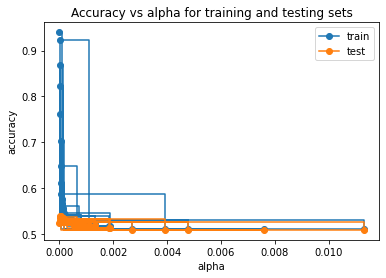

In [ ]:
train_scores = [clf.score(x_train_w2v, y_train_w2v) for clf in clfs]
test_scores = [clf.score(x_val_w2v, y_val_w2v) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
ccp_alphas=DataFrame(ccp_alphas,columns=["alpha"])
train_scores=DataFrame(train_scores,columns=["training accuracy"])
test_scores=DataFrame(test_scores,columns=["test accuracy"])
alpha_grid=ccp_alphas.join([train_scores,test_scores],on=None, how="left",sort=False)
optim_alpha_top5=alpha_grid.sort_values(by='test accuracy', ascending=False).head(5)
alpha=list(set(optim_alpha_top5.alpha))
alpha

[4e-05, 5e-05, 6e-05, 3e-05, 7e-05]

In [ ]:
optim_alpha_top5

,alpha,training accuracy,test accuracy
6,0.00005,0.702459,0.539365
18,0.00004,0.761099,0.538895
60,0.00006,0.649073,0.537208
48,0.00007,0.612027,0.535969
28,0.00003,0.821927,0.535115


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.7195858735651123

Accuracy on validation data:  0.588320731342646


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1,n_neighbors=7).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.6871532926896249

Accuracy on validation data:  0.5827886710239651


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1,n_neighbors=10).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.6535764632650446

Accuracy on validation data:  0.5772352513990345


In [20]:
knn = KNeighborsClassifier(n_jobs=-1,weights="distance",n_neighbors=10).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9401329159114626

Accuracy on validation data:  0.6112392669486095


In [22]:
knn = KNeighborsClassifier(n_jobs=-1,weights="distance",n_neighbors=6).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9400871459694989

Accuracy on validation data:  0.6130334486735871


In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', rf.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9401420698998554

Accuracy on validation data:  0.6225383399547183


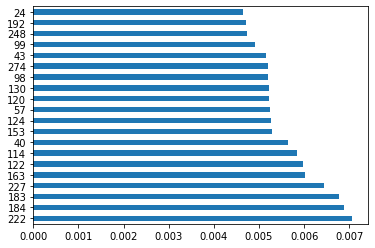

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=x_train_w2v.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_us, y_train_us)

print('Accuracy on training data: ', rf.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9465655471289274

Accuracy on validation data:  0.6158528770985519


In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_smote, y_train_smote)

print('Accuracy on training data: ', rf.score(x_train_smote, y_train_smote))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9627321022008601

Accuracy on validation data:  0.5322311931308471


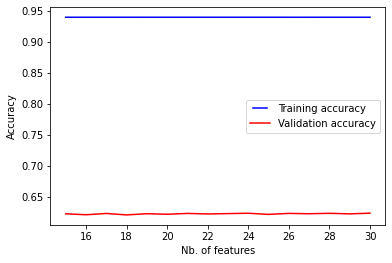

In [ ]:
max_features = np.linspace(15, 30, 15, endpoint=True)

max_features = max_features.astype(int)
train_results = []
val_results = []
for max_nb_ft in max_features:
   rf = RandomForestClassifier(max_features=max_nb_ft, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Training accuracy")
line2, = plt.plot(max_features, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Nb. of features')
plt.show()

In [ ]:
val_results

[0.6223674655047204,
 0.6207868768422402,
 0.622880088854714,
 0.6205305651672434,
 0.6224956213422188,
 0.6215771711734803,
 0.6229441667734632,
 0.6220897945234739,
 0.6232431970609594,
 0.6214062967234825,
 0.6229868853859627,
 0.6224315434234696,
 0.6231364005297108,
 0.6222179503609723,
 0.6233713528984579]

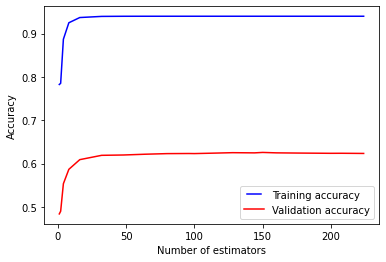

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32 ,48, 64, 80, 96,100, 112, 128, 144, 150,160,176,200,208,224]
train_results = []
val_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator,max_features=30, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Training accuracy")
line2, = plt.plot(n_estimators, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Number of estimators')
plt.show()

In [ ]:
val_results

[0.4838310051689521,
 0.49002520398137467,
 0.5535904993805801,
 0.5867615019864155,
 0.6091033363236362,
 0.6190781323422615,
 0.6198470673672519,
 0.6216412490922295,
 0.6230296039984621,
 0.6232859156734589,
 0.6231150412234611,
 0.6239694134734504,
 0.6251868939296852,
 0.6247597078046905,
 0.625763595198428,
 0.6247810671109403,
 0.6243111623734461,
 0.6237344611047033,
 0.6238198983297023,
 0.6234354308172071]

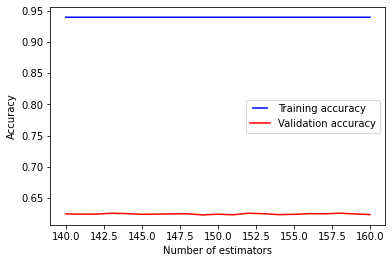

In [ ]:
n_estimators = np.linspace(140, 160, 20, endpoint=True)
n_estimators = n_estimators.astype(int)

train_results = []
val_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(random_state=0,n_estimators=estimator,warm_start=True,max_features=30, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Training accuracy")
line2, = plt.plot(n_estimators, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Number of estimators')
plt.show()


In [ ]:
n_estimators=DataFrame(n_estimators,columns=["Nb. of trees"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
tree_grid=n_estimators.join([train_results,val_results],on=None, how="left",sort=False)
tree_grid_top5=tree_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
tree_grid_top5

,Nb. of trees,Training accuracy,Validation accuracy
18,158,0.940142,0.625294
12,152,0.940142,0.625230
3,143,0.940142,0.625187
4,144,0.940133,0.624653
16,156,0.940142,0.624546


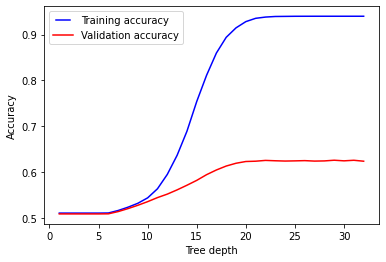

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
val_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(random_state=0,max_depth=max_depth,max_features=30,n_estimators=158,n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Training accuracy")
line2, = plt.plot(max_depths, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
max_depths=DataFrame(max_depths,columns=["Max. depth"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
max_depth_grid=max_depths.join([train_results,val_results],on=None, how="left",sort=False)
max_depth_grid_top5=max_depth_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
max_depth_grid_top5

,Max. depth,Training accuracy,Validation accuracy
28,29.0,0.940142,0.625892
30,31.0,0.940142,0.625785
21,22.0,0.938339,0.625486
25,26.0,0.940105,0.624995
22,23.0,0.939620,0.624696


In [ ]:
rf = RandomForestClassifier(random_state=0,max_depth=29,max_features=30,n_estimators=158,n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', rf.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9401420698998554

Accuracy on validation data:  0.6258917510359263


In [ ]:
rf = RandomForestClassifier().fit(x_train_w2v, y_train_w2v)

param_grid =  {'criterion':['gini'],
                                  'random_state': [0],
                                  'bootstrap': [True],
                                  'max_features': [30],
                                  'max_depth' : [29,30,31],
                                  'n_estimators': [157,158,159]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(x_train_w2v, y_train_w2v)
clf_performance(best_clf_rf,'Random Forest')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 260.2min finished


Random Forest
Best Score: 0.610516105086855
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 29, 'max_features': 30, 'n_estimators': 157, 'random_state': 0}


In [ ]:
rf = RandomForestClassifier(random_state=0,max_depth=29,max_features=30,n_estimators=157,n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', rf.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9401420698998554

Accuracy on validation data:  0.6237771797172028


In [ ]:
abc = AdaBoostClassifier().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', abc.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', abc.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5488548360520679

Accuracy on validation data:  0.5484429065743944


In [ ]:
gbc = GradientBoostingClassifier().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', gbc.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', gbc.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.604923014957617

Accuracy on validation data:  0.5897090862488786


In [ ]:
xgb = XGBClassifier(random_state =1, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
print('Accuracy on training data: ', xgb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', xgb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5909906446238626

Accuracy on validation data:  0.5542312785680721


In [ ]:
from tensorflow import keras
import IPython
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.6MB/s 


In [ ]:
# I start by attempting to find the best setting for a feed-forward network with 1 hidden layer.

import kerastuner as kt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_12', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal activation function is {best_hps.get('dense_activation')}. 
""")

Trial 90 Complete [00h 00m 39s]
val_accuracy: 0.5086932182312012

Best val_accuracy So Far: 0.5452176332473755
Total elapsed time: 00h 19m 02s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 312 and the optimal learning rate for the optimizer
is 0.001. The optimal activation function is selu. 



In [ ]:
#I now fit the optimal model above with 1 hidden layer and supervise the evolution of accuracy per epoch.

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)
epochs = 160
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
model.add(Dense(516, activation='selu', input_shape=(300,)))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/160
114/114 [==============================] - 3s 27ms/step - loss: 1.4304 - accuracy: 0.4715 - val_loss: 1.2483 - val_accuracy: 0.5210
Epoch 2/160
114/114 [==============================] - 3s 25ms/step - loss: 1.2312 - accuracy: 0.5203 - val_loss: 1.1908 - val_accuracy: 0.5318
Epoch 3/160
114/114 [==============================] - 3s 25ms/step - loss: 1.1704 - accuracy: 0.5343 - val_loss: 1.1416 - val_accuracy: 0.5405
Epoch 4/160
114/114 [==============================] - 3s 25ms/step - loss: 1.1452 - accuracy: 0.5396 - val_loss: 1.1072 - val_accuracy: 0.5503
Epoch 5/160
114/114 [==============================] - 3s 25ms/step - loss: 1.1140 - accuracy: 0.5490 - val_loss: 1.1141 - val_accuracy: 0.5458
Epoch 6/160
114/114 [==============================] - 3s 25ms/step - loss: 1.1005 - accuracy: 0.5526 - val_loss: 1.1093 - val_accuracy: 0.5468
Epoch 7/160
114/114 [==============================] - 3s 25ms/step - loss: 1.1082 - accuracy: 0.5515 - val_loss: 1.0971 - val_accuracy:

In [ ]:
score_train=model.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=model.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 1s 10ms/step - loss: 1.0159 - accuracy: 0.5729


['loss', 'accuracy']

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    model.add(Dense(units=hp.Int('units_0',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation_0',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    )))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_13', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -{best_hps.get('units')} for the first layer,
 -{best_hps.get('units_0')} for the second layer.

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 

The optimal activation functions are:
 -{best_hps.get('dense_activation')} for the first layer,
 -{best_hps.get('dense_activation_0')} for the second layer.
 """)

Trial 90 Complete [00h 00m 48s]
val_accuracy: 0.5478448271751404

Best val_accuracy So Far: 0.5575847029685974
Total elapsed time: 00h 35m 38s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -632 for the first layer,
 -352 for the second layer.

The optimal learning rate for the optimizer is 0.001. 

The optimal activation functions are:
 -relu for the first layer,
 -elu for the second layer.
 


In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)


epochs = 240
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
model.add(Dense(632, activation='relu', input_shape=(300,)))
model.add(Dense(352, activation='elu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/240
114/114 [==============================] - 7s 57ms/step - loss: 1.3605 - accuracy: 0.4815 - val_loss: 1.2130 - val_accuracy: 0.5252
Epoch 2/240
114/114 [==============================] - 6s 55ms/step - loss: 1.1946 - accuracy: 0.5268 - val_loss: 1.1254 - val_accuracy: 0.5406
Epoch 3/240
114/114 [==============================] - 6s 54ms/step - loss: 1.1336 - accuracy: 0.5430 - val_loss: 1.1476 - val_accuracy: 0.5442
Epoch 4/240
114/114 [==============================] - 6s 54ms/step - loss: 1.0994 - accuracy: 0.5521 - val_loss: 1.0711 - val_accuracy: 0.5651
Epoch 5/240
114/114 [==============================] - 6s 54ms/step - loss: 1.0796 - accuracy: 0.5580 - val_loss: 1.0913 - val_accuracy: 0.5572
Epoch 6/240
114/114 [==============================] - 6s 55ms/step - loss: 1.0725 - accuracy: 0.5631 - val_loss: 1.0904 - val_accuracy: 0.5558
Epoch 7/240
114/114 [==============================] - 6s 55ms/step - loss: 1.0711 - accuracy: 0.5622 - val_loss: 1.0524 - val_accuracy:

In [ ]:
score_train=model.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=model.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 1s 19ms/step - loss: 0.9605 - accuracy: 0.6070


['loss', 'accuracy']

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    for i in range(hp.Int('num_layers', 1, 2)):
          model.add(Dense(units=hp.Int('units_' + str(i),min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation_' + str(i),
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    )))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_14', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -{best_hps.get('units')} for the first layer,
 -{best_hps.get('units_0')} for the second layer,
 -{best_hps.get('units_1')} for the third layer.

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 

The optimal activation functions are:
 -{best_hps.get('dense_activation')} for the first layer,
 -{best_hps.get('dense_activation_0')} for the second layer,
 -{best_hps.get('dense_activation_1')} for the third layer.
 """)

Trial 90 Complete [00h 03m 55s]
val_accuracy: 0.5633944272994995

Best val_accuracy So Far: 0.5633944272994995
Total elapsed time: 00h 47m 05s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -252 for the first layer,
 -472 for the second layer,
 -612 for the third layer.

The optimal learning rate for the optimizer is 0.001. 

The optimal activation functions are:
 -tanh for the first layer,
 -relu for the second layer,
 -relu for the third layer.
 


In [ ]:


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)


epochs = 32
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
model.add(Dense(252, activation='tanh', input_shape=(300,)))
model.add(Dense(472, activation='relu'))
model.add(Dense(612, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/32
114/114 [==============================] - 9s 77ms/step - loss: 1.2811 - accuracy: 0.4928 - val_loss: 1.1538 - val_accuracy: 0.5456
Epoch 2/32
114/114 [==============================] - 8s 69ms/step - loss: 1.1570 - accuracy: 0.5357 - val_loss: 1.1099 - val_accuracy: 0.5478
Epoch 3/32
114/114 [==============================] - 8s 70ms/step - loss: 1.1099 - accuracy: 0.5478 - val_loss: 1.1415 - val_accuracy: 0.5418
Epoch 4/32
114/114 [==============================] - 8s 70ms/step - loss: 1.0734 - accuracy: 0.5600 - val_loss: 1.0210 - val_accuracy: 0.5717
Epoch 5/32
114/114 [==============================] - 8s 70ms/step - loss: 1.0909 - accuracy: 0.5532 - val_loss: 1.0853 - val_accuracy: 0.5509
Epoch 6/32
114/114 [==============================] - 8s 70ms/step - loss: 1.0685 - accuracy: 0.5651 - val_loss: 1.0194 - val_accuracy: 0.5755
Epoch 7/32
114/114 [==============================] - 8s 70ms/step - loss: 1.0159 - accuracy: 0.5804 - val_loss: 1.0778 - val_accuracy: 0.5647

In [ ]:
score_train=model.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=model.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 1s 21ms/step - loss: 0.9699 - accuracy: 0.6030


['loss', 'accuracy']

## Fitting the final model on the test data and making the submission

The best model (with a validation accuracy of 60.70%)  that does not significantly over-fit the data consists of a feed-forward neural network with two hidden layers. Although both the tuned random forest and k-nearest neighbours classifiers have very slightly higher accuracies, these two models strongly over-fit the data.

In [ ]:
best_neural_network_pred = pd.DataFrame(model.predict_classes(x_test_w2v),columns=["Sentiment"])

#convert output to dataframe 
final_data = {'PhraseId': test.PhraseId, 'Sentiment': best_neural_network_pred.Sentiment}

In [ ]:
submission_1 = pd.DataFrame(data=final_data)
submission_1.head()

,PhraseId,Sentiment
0,1,3
1,2,2
2,3,2
3,4,3
4,5,2


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
submission_1.to_csv("/content/drive/MyDrive/Rotten tomatoes/Rotten_Tomatoes_sentiment_classification_submission_1.csv",index=False)